# Anomaly detection with Autoencoder

In [0]:
# !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"
# base_dir = root_dir + 'dashlink/'

In [0]:
from fastai.vision import *
import torchvision
import torchvision.transforms as T
from torchvision import datasets
import torch

In [0]:
trnpath = Path(base_dir + 'Train'); trnpath

PosixPath('/content/gdrive/My Drive/dashlink/Train')

In [0]:
# set output folder
outpath = Path('png4a'); outpath

PosixPath('png4a')

In [0]:
! ls -alh "{trnpath}"/{outpath}

total 19M
-rw------- 1 root root  19M Sep 28 15:47 autoencoder.pkl
drwx------ 2 root root 4.0K Sep 28 11:52 non
drwx------ 2 root root 4.0K Sep 28 11:53 typ


## Ingest data

---



In [0]:
from PIL import Image
import PIL.ImageOps
from torch.utils.data import Dataset, DataLoader

class AutoencoderDataset(Dataset):
  def __init__(self, data_dir, transform):      
    # store filenames
    self.filenames = os.listdir(data_dir)
    self.filenames = [os.path.join(data_dir, f) for f in self.filenames] 
    self.transform = transform
      
  def __len__(self):
    # return size of dataset
    return len(self.filenames)
      
  def __getitem__(self, idx):
    # open image, convert from 4 to 3 channels, apply transforms, and return
  
    png = Image.open(self.filenames[idx])
    
    r,g,b,a = png.split()
    rgb_img = Image.merge('RGB', (r,g,b))
    out = rgb_img
    
    out = out.convert('L') #Luminosity, only 1 channel
    out = PIL.ImageOps.invert(out) #invert
    
    out = self.transform(out)
    return np.array(out)

In [0]:
bs = 8
# bs = 16
# bs = 32

### Create Datasets

#### Normal

In [0]:
#Compose means applied in a sequence
train_transform = T.Compose([T.Resize([128,128]), T.ToTensor()])

In [0]:
# norm_dataset = AutoencoderDataset(str(trnpath/'png4a'/'typ'), train_transform)
norm_dataset = AutoencoderDataset(str(trnpath/outpath/'typ'), train_transform)
len(norm_dataset)

993

In [0]:
norm_dataset[0].shape

(1, 128, 128)

##### Split into train/valid

In [0]:
train_size = int(0.8*len(norm_dataset)); print(train_size)
valid_size = len(norm_dataset) - train_size; print(valid_size)

794
199


In [0]:
train_norm_dataset,valid_norm_dataset = torch.utils.data.random_split(
    norm_dataset, [train_size, valid_size])
len(train_norm_dataset),len(valid_norm_dataset)

(794, 199)

#### Anomalous

In [0]:
# anom_dataset = AutoencoderDataset(str(trnpath/'png4a'/'non'), train_transform)
anom_dataset = AutoencoderDataset(str(trnpath/outpath/'non'), train_transform)
len(anom_dataset)

87

In [0]:
anom_dataset[0].shape

(1, 128, 128)

### Create DataLoaders

In [0]:
train_norm_loader = torch.utils.data.DataLoader(train_norm_dataset, batch_size=bs, shuffle=True)
valid_norm_loader = torch.utils.data.DataLoader(valid_norm_dataset, batch_size=bs, shuffle=False)

In [0]:
anom_loader = torch.utils.data.DataLoader(anom_dataset, batch_size=bs, shuffle=True)

### Show a batch of normal images

In [0]:
def show_random_batch(loader, loader_name):
  xb = iter(loader).next(); print(xb.shape)
  images = torchvision.utils.make_grid(xb); print(images.shape)
  images = np.transpose(images, (1,2,0)); print(images.shape)
  plt.figure(figsize=(15,12))
  plt.title(f'Random batch from loader: {loader_name}')
  plt.imshow(images)
  plt.show() 

torch.Size([8, 1, 128, 128])
torch.Size([3, 132, 1042])
torch.Size([132, 1042, 3])


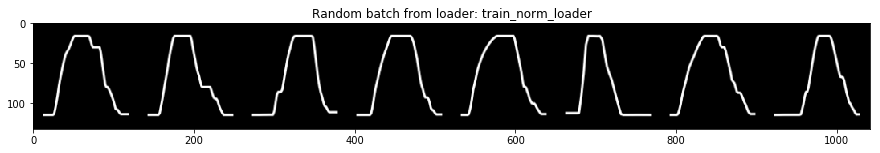

torch.Size([8, 1, 128, 128])
torch.Size([3, 132, 1042])
torch.Size([132, 1042, 3])


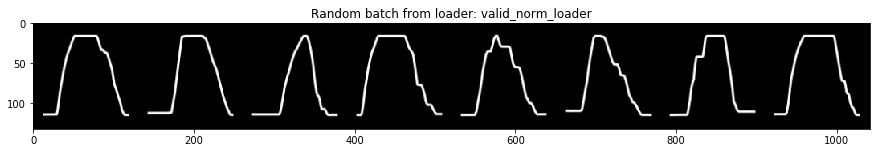

torch.Size([8, 1, 128, 128])
torch.Size([3, 132, 1042])
torch.Size([132, 1042, 3])


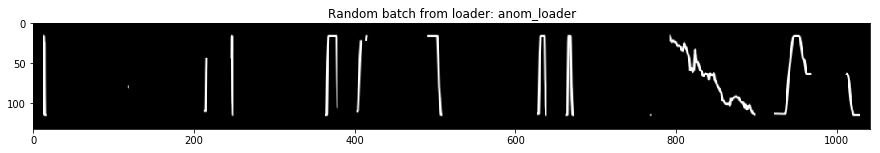

In [0]:
show_random_batch(train_norm_loader, 'train_norm_loader')
show_random_batch(valid_norm_loader, 'valid_norm_loader')
show_random_batch(anom_loader, 'anom_loader')

## Model

In [0]:
class LinearAutoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(LinearAutoencoder, self).__init__()
    #encoder
    self.fc1e = nn.Linear(1*128*128, encoding_dim)
    #self.fc2e = nn.Linear(1024, encoding_dim)

    #decoder
    #self.fc2d = nn.Linear(encoding_dim, 1024)
    self.fc1d = nn.Linear(encoding_dim, 1*128*128)
    
  def forward(self, x):
    x = F.relu(self.fc1e(x))
    #x = F.relu(self.fc2e(x))
    
    #x = F.relu(self.fc2d(x))
    x = torch.sigmoid(self.fc1d(x)) #scaling from 0 to 1
    return x

In [0]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()
    self.conv1e = nn.Conv2d(  1,  24, 3, padding=2)
    self.conv2e = nn.Conv2d( 24,  48, 3, padding=2)
    self.conv3e = nn.Conv2d( 48,  96, 3, padding=2)
    self.conv4e = nn.Conv2d( 96, 128, 3, padding=2)
    self.conv5e = nn.Conv2d(128, 256, 3, padding=2)
    self.mp1e   = nn.MaxPool2d(2, return_indices=True)

    self.mp1d   = nn.MaxUnpool2d(2)
    self.conv5d = nn.ConvTranspose2d(256, 128, 3, padding=2)
    self.conv4d = nn.ConvTranspose2d(128,  96, 3, padding=2)
    self.conv3d = nn.ConvTranspose2d( 96,  48, 3, padding=2)
    self.conv2d = nn.ConvTranspose2d( 48,  24, 3, padding=2)
    self.conv1d = nn.ConvTranspose2d( 24,   1, 3, padding=2)
    
  def forward(self, x):
    #Encoder
    x = F.relu(self.conv1e(x))
    x = F.relu(self.conv2e(x))
    x = F.relu(self.conv3e(x))
    x = F.relu(self.conv4e(x))
    x = F.relu(self.conv5e(x))
    x,i = self.mp1e(x)
    #Decoder
    x = self.mp1d(x, i)
    x = F.relu(self.conv5d(x))
    x = F.relu(self.conv4d(x))
    x = F.relu(self.conv3d(x))
    x = F.relu(self.conv2d(x))
    x = F.relu(self.conv1d(x))    
    return x

In [0]:
class ConvAutoencoder2(nn.Module):
  def __init__(self):
    super(ConvAutoencoder2, self).__init__()
    #encoder
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 8, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)    
    #decoder
    self.t_conv1 = nn.ConvTranspose2d(8, 32, 2, stride=2)
    self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)
    
  def forward(self, x):
    #Encoder
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    #Decoder
    x = F.relu(self.t_conv1(x))
    x = torch.sigmoid(self.t_conv2(x))
    return x

In [0]:
# learning_rate = 1e-3 #.973
# learning_rate = 2e-3 #
learning_rate = 3e-3 #
# learning_rate = 5e-3 #
# learning_rate = 1e-2 #

In [0]:
# autoencoder = LinearAutoencoder(16).cuda() #.91
# autoencoder = LinearAutoencoder(24).cuda() #.89
# autoencoder = LinearAutoencoder(28).cuda() #.86
# autoencoder = LinearAutoencoder(32).cuda() #.88
# autoencoder = LinearAutoencoder(36).cuda() #.88
# autoencoder = LinearAutoencoder(40).cuda() #.89
# autoencoder = LinearAutoencoder(44).cuda() #.87
# autoencoder = LinearAutoencoder(48).cuda() #.87
# autoencoder = LinearAutoencoder(52).cuda() #.86
# autoencoder = LinearAutoencoder(56).cuda() #.86
# autoencoder = LinearAutoencoder(60).cuda() #.855
# autoencoder = LinearAutoencoder(64).cuda() #.84
# autoencoder = LinearAutoencoder(68).cuda() #.85
# autoencoder = LinearAutoencoder(72).cuda() #.84
# autoencoder = LinearAutoencoder(76).cuda() #.85
# autoencoder = LinearAutoencoder(80).cuda() #.84
# autoencoder = LinearAutoencoder(84).cuda() #.85
# autoencoder = LinearAutoencoder(88).cuda() #.84
# autoencoder = LinearAutoencoder(92).cuda() #.84
# autoencoder = LinearAutoencoder(96).cuda() #.84
# autoencoder = LinearAutoencoder(100).cuda() #.84
# autoencoder = LinearAutoencoder(104).cuda() #.84
# autoencoder = LinearAutoencoder(108).cuda() #.84
# autoencoder = LinearAutoencoder(112).cuda() #.84
# autoencoder = LinearAutoencoder(116).cuda() #.84
# autoencoder = LinearAutoencoder(120).cuda() #.84
# autoencoder = LinearAutoencoder(124).cuda() #.84
# autoencoder = LinearAutoencoder(128).cuda() #.84
# autoencoder = LinearAutoencoder(136).cuda() #.84
# autoencoder = LinearAutoencoder(142).cuda() #.83
autoencoder = LinearAutoencoder(150).cuda() #.82
# autoencoder = LinearAutoencoder(158).cuda() #.83
# autoencoder = LinearAutoencoder(166).cuda() #.83
# autoencoder = LinearAutoencoder(174).cuda() #.83
# autoencoder = LinearAutoencoder(182).cuda() #.82
# autoencoder = LinearAutoencoder(190).cuda() #.84
# autoencoder = LinearAutoencoder(198).cuda() #.83

# autoencoder = LinearAutoencoder(228).cuda() #.82
# autoencoder = LinearAutoencoder(256).cuda() #.83
# autoencoder = LinearAutoencoder(512).cuda() #.82
# autoencoder = LinearAutoencoder(1024).cuda() #.87

# autoencoder = ConvAutoencoder().cuda()
# autoencoder = ConvAutoencoder2().cuda()
print(autoencoder)

LinearAutoencoder(
  (fc1e): Linear(in_features=16384, out_features=150, bias=True)
  (fc1d): Linear(in_features=150, out_features=16384, bias=True)
)


In [0]:
# parameters = list(autoencoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

## Train on normal images

In [0]:
def show_img(orig, reconstructed):
    fig=plt.figure()
        
    fig.add_subplot(1, 3, 1, title='Original')
    plt.imshow(orig)
    
    fig.add_subplot(1, 3, 3, title='Reconstructed')
    plt.imshow(reconstructed)
    
    fig.subplots_adjust(wspace = 0.5)
    plt.show()

In [0]:
train_loss = []
valid_loss = []

In [0]:
epochs = 15
for epoch in range(1, epochs+1):
    #if(epoch==2): break
    # Train the model
    total_trn_loss = 0.0
    total_trn_iter = 0
    autoencoder.train()
    for i,xb in enumerate(train_norm_loader):
        xb = xb.view(xb.size(0), -1) #for 1D to flatten image into vector
        xb = xb.cuda()
        optimizer.zero_grad()
        yhb = autoencoder(xb)
        
        loss = loss_func(yhb, xb)
        loss.backward()
        optimizer.step()
        
        total_trn_iter += 1
        total_trn_loss += loss.item()
        
    # Record the validation loss
    total_val_loss = 0.0
    total_val_iter = 0
    autoencoder.eval()
    for i,xb in enumerate(valid_norm_loader):
        xb = xb.view(xb.size(0), -1) #for 1D to flatten image into vector
        xb = xb.cuda()
        yhb = autoencoder(xb)

        loss = loss_func(yhb, xb)
        
        total_val_iter += 1
        total_val_loss += loss.item()
        
    # Visualize the first image of the last batch in our validation set
#     orig = xb[0].cpu()
#     orig = xb[0].view(128, 128).cpu()
#     reconstructed = yhb[0].cpu()
#     reconstructed = yhb[0].view(128, 128).cpu()
#     print("... after Epoch", epoch)
#     #show_img(orig.data.numpy(), reconstructed.data.numpy())
#     show_img(orig, reconstructed)
    
    train_loss.append(total_trn_loss / total_trn_iter)
    valid_loss.append(total_val_loss / total_val_iter)
    print(f'train_loss: {train_loss[-1]},    valid_loss: {valid_loss[-1]}')

train_loss: 0.039925648216158155,    valid_loss: 0.03281472072005272
train_loss: 0.03202095489948988,    valid_loss: 0.03156387336552143
train_loss: 0.029728926308453082,    valid_loss: 0.026531135216355323
train_loss: 0.0220369840413332,    valid_loss: 0.018517025373876096
train_loss: 0.015924605578184127,    valid_loss: 0.015274132490158082
train_loss: 0.012745676143094898,    valid_loss: 0.013521087914705276
train_loss: 0.010640565771609545,    valid_loss: 0.012676451094448567
train_loss: 0.009377907132729887,    valid_loss: 0.012056877054274082
train_loss: 0.008440617872402072,    valid_loss: 0.011607866175472737
train_loss: 0.00771296959836036,    valid_loss: 0.011376393251121044
train_loss: 0.007279713810421526,    valid_loss: 0.01110190998762846
train_loss: 0.006743961218744516,    valid_loss: 0.011048764772713184
train_loss: 0.006398786115460098,    valid_loss: 0.010919519141316414
train_loss: 0.006109245258849114,    valid_loss: 0.010775629114359617
train_loss: 0.0060210713976

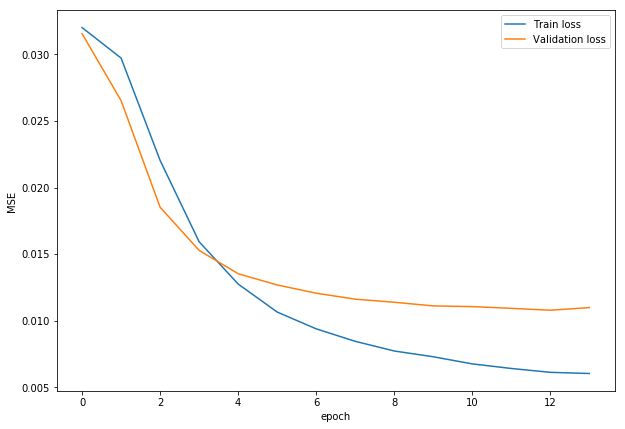

In [0]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_loss[1:], label='Train loss')
plt.plot(valid_loss[1:], label='Validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [0]:
# save model
# torch.save(autoencoder.state_dict(), str(trnpath/outpath/'autoencoder.pth'))
torch.save(autoencoder, str(trnpath/outpath/'autoencoder.pkl'))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LinearAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
!ls "{trnpath}"/{outpath}

autoencoder.pkl  non  typ


## Distribution of MSE for anomalous images

In [0]:
#summary
autoencoder.eval()
for i,xb in enumerate(anom_loader):
    xb = xb.view(xb.size(0), -1) #for 1D to flatten image into vector
    xb = xb.cuda()
    yhb = autoencoder(xb)
    loss = loss_func(yhb, xb)
    print('Batch: {} \tvalid_loss: {:.6f}'.format(i, loss.item()))

Batch: 0 	valid_loss: 0.025851
Batch: 1 	valid_loss: 0.027579
Batch: 2 	valid_loss: 0.033918
Batch: 3 	valid_loss: 0.035901
Batch: 4 	valid_loss: 0.033967
Batch: 5 	valid_loss: 0.030512
Batch: 6 	valid_loss: 0.029304
Batch: 7 	valid_loss: 0.033208
Batch: 8 	valid_loss: 0.035582
Batch: 9 	valid_loss: 0.035837
Batch: 10 	valid_loss: 0.033844


mu_anom = 0.032301 	sig_anom = 0.011641


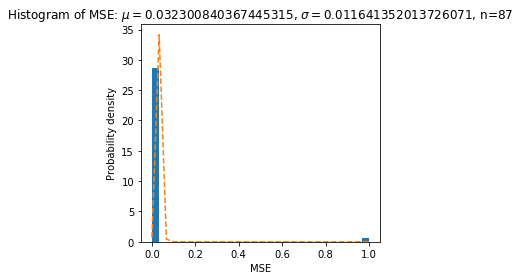

In [0]:
n_anom = 0
valid_losses = []
autoencoder.eval()
for i,xb in enumerate(anom_loader):
    xb = xb.view(xb.size(0), -1) #for 1D to flatten image into vector
    xb = xb.cuda()
    for x in xb:
      yh = autoencoder(x)
      loss = loss_func(yh, x)
      valid_losses.append(loss.item())
      n_anom += 1
      #print('Batch: {} \tvalid_loss: {:.6f}'.format(i, loss.item()))
      #print(f'{loss.item()}')
losses = np.array(valid_losses)
mu_anom,sig_anom = losses.mean(),losses.std()
print('mu_anom = {:.6f} \tsig_anom = {:.6f}'.format(mu_anom, sig_anom))
num_bins = 30

fig, ax = plt.subplots()
n, bins, patches = ax.hist(x, num_bins, density=1)
y = ((1/(np.sqrt(2*np.pi)*sig_anom))*np.exp(-0.5*(1/sig_anom*(bins-mu_anom))**2)) #'best fit' line
ax.plot(bins, y, '--')
ax.set_xlabel('MSE')
ax.set_ylabel('Probability density')
ax.set_title(f'Histogram of MSE: $\mu={mu_anom}$, $\sigma={sig_anom}$, n={n_anom}')
fig.tight_layout() #Tweak spacing to prevent clipping of ylabel
plt.show()

In [0]:
print('mu_anom = {:.6f} \tsig_anom = {:.6f}'.format(mu_anom, sig_anom))

mu_anom = 0.032301 	sig_anom = 0.011641


## Distribution of MSE for normal validation images

In [0]:
#summary
autoencoder.eval()
for i,xb in enumerate(valid_norm_loader):
    xb = xb.view(xb.size(0), -1) #for 1D to flatten image into vector
    xb = xb.cuda()
    yhb = autoencoder(xb)
    loss = loss_func(yhb, xb)
    print('Batch: {} \tvalid_loss: {:.6f}'.format(i, loss.item()))

Batch: 0 	valid_loss: 0.011499
Batch: 1 	valid_loss: 0.010799
Batch: 2 	valid_loss: 0.013847
Batch: 3 	valid_loss: 0.013679
Batch: 4 	valid_loss: 0.010948
Batch: 5 	valid_loss: 0.009792
Batch: 6 	valid_loss: 0.011477
Batch: 7 	valid_loss: 0.008417
Batch: 8 	valid_loss: 0.008989
Batch: 9 	valid_loss: 0.010478
Batch: 10 	valid_loss: 0.012804
Batch: 11 	valid_loss: 0.009284
Batch: 12 	valid_loss: 0.012407
Batch: 13 	valid_loss: 0.010427
Batch: 14 	valid_loss: 0.010192
Batch: 15 	valid_loss: 0.011031
Batch: 16 	valid_loss: 0.014427
Batch: 17 	valid_loss: 0.009606
Batch: 18 	valid_loss: 0.011417
Batch: 19 	valid_loss: 0.014722
Batch: 20 	valid_loss: 0.009367
Batch: 21 	valid_loss: 0.007768
Batch: 22 	valid_loss: 0.012022
Batch: 23 	valid_loss: 0.007459
Batch: 24 	valid_loss: 0.011533


mu_norm = 0.010973 	sig_norm = 0.004875


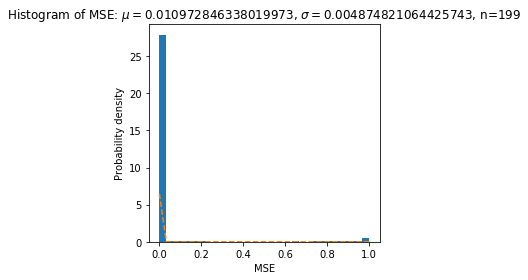

In [0]:
n_norm = 0
valid_losses = []
autoencoder.eval()
for i,xb in enumerate(valid_norm_loader):
    xb = xb.view(xb.size(0), -1) #for 1D to flatten image into vector
    xb = xb.cuda()
    for x in xb:
      yh = autoencoder(x)
      loss = loss_func(yh, x)
      valid_losses.append(loss.item())
      n_norm += 1
      #print('Batch: {} \tvalid_loss: {:.6f}'.format(i, loss.item()))
      #print(f'{loss.item()}')
losses = np.array(valid_losses)
mu_norm,sig_norm = losses.mean(),losses.std()
print('mu_norm = {:.6f} \tsig_norm = {:.6f}'.format(mu_norm, sig_norm))
num_bins = 30

fig, ax = plt.subplots()
n, bins, patches = ax.hist(x, num_bins, density=1)
y = ((1/(np.sqrt(2*np.pi)*sig_norm))*np.exp(-0.5*(1/sig_norm*(bins-mu_norm))**2)) #'best fit' line
ax.plot(bins, y, '--')
ax.set_xlabel('MSE')
ax.set_ylabel('Probability density')
ax.set_title(f'Histogram of MSE: $\mu={mu_norm}$, $\sigma={sig_norm}$, n={n_norm}')
fig.tight_layout() #Tweak spacing to prevent clipping of ylabel
plt.show()

In [0]:
print('mu_norm = {:.6f} \tsig_norm = {:.6f}'.format(mu_norm, sig_norm))

mu_norm = 0.010973 	sig_norm = 0.004875


In [0]:
print('mu_anom = {:.6f} \tsig_anom = {:.6f}'.format(mu_anom, sig_anom))
print('mu_norm = {:.6f} \tsig_norm = {:.6f}'.format(mu_norm, sig_norm))

mu_anom = 0.032301 	sig_anom = 0.011641
mu_norm = 0.010973 	sig_norm = 0.004875


In [0]:
threshold = np.array([mu_anom, mu_norm]).mean(); threshold
print('threshold = {:.6f}'.format(threshold))

threshold = 0.021637


In [0]:
print('threshold = {:.6f}'.format(threshold))

threshold = 0.021637


## Show some reconstructions

In [0]:
def show_random_batch_reconstructions(loader):
  X = iter(loader).next(); print(X.shape)
  # X = X[0].unsqueeze(0); print(X.shape)
  X_flat = X.view(X.size(0), -1); print(X_flat.shape)
  Yh_flat = autoencoder(X_flat.cuda()); print(Yh_flat.shape)
  Yh = Yh_flat.view(X.size(0), 1, 128, 128); print(Yh.shape)

  # Yh = autoencoder(X.cuda()); print(Yh.shape)

  #prepare for visualization
  X_vis = X.numpy(); print(X_vis.shape)
  Yh_vis = Yh.detach().cpu().numpy(); print(Yh_vis.shape)
  #visualize; originals in top row, reconstructions in bottom row
  fig,axes = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(15,4))
  for X_vis,row in zip([X_vis, Yh_vis], axes):
    for img,ax in zip(X_vis, row):
      ax.imshow(np.squeeze(img), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  

torch.Size([8, 1, 128, 128])
torch.Size([8, 16384])
torch.Size([8, 16384])
torch.Size([8, 1, 128, 128])
(8, 1, 128, 128)
(8, 1, 128, 128)


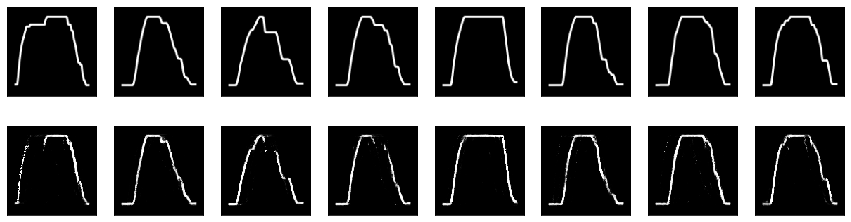

In [0]:
show_random_batch_reconstructions(train_norm_loader)

torch.Size([8, 1, 128, 128])
torch.Size([8, 16384])
torch.Size([8, 16384])
torch.Size([8, 1, 128, 128])
(8, 1, 128, 128)
(8, 1, 128, 128)


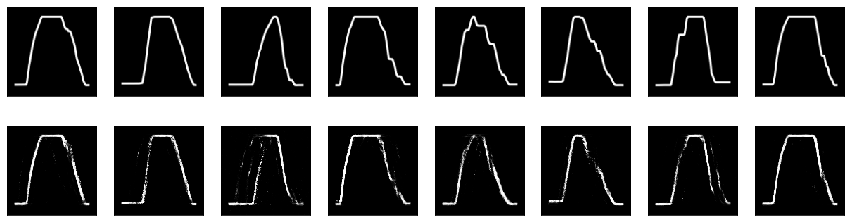

In [0]:
show_random_batch_reconstructions(valid_norm_loader)

torch.Size([8, 1, 128, 128])
torch.Size([8, 16384])
torch.Size([8, 16384])
torch.Size([8, 1, 128, 128])
(8, 1, 128, 128)
(8, 1, 128, 128)


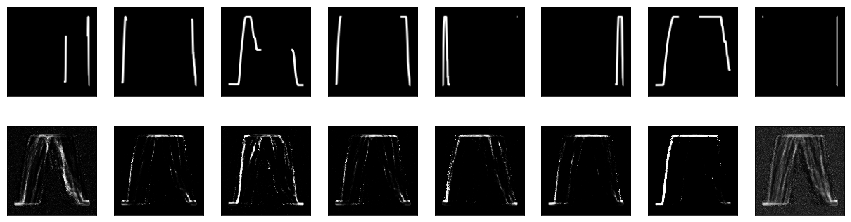

In [0]:
show_random_batch_reconstructions(anom_loader)

## Interpretation

In [0]:
model = torch.load(trnpath/'png4a'/'autoencoder.pkl', map_location='cpu')
model.eval()

LinearAutoencoder(
  (fc1e): Linear(in_features=16384, out_features=150, bias=True)
  (fc1d): Linear(in_features=150, out_features=16384, bias=True)
)

In [0]:
#Actual  (anomalous profiles, non)
loss_func = nn.MSELoss()
model.eval()
n = len(anom_dataset)
TN = 0; FP = 0
print(f'TOTAL FILES TO PROCESS: {n}\n')
for i,xb in enumerate(anom_loader):
  #if i==2: break
  xb = xb.view(xb.size(0), -1) #for 1D to flatten image into vector
  for x in xb:  
    yh = model(x)
    loss = loss_func(yh, x)
    recon_loss = loss.item()
    if recon_loss < threshold:
      FP += 1
    else:
      TN += 1
    #print(f'{1} of {n} complete ........................\n')
print(f'True Negatives: {TN}\tFalse Positives: {FP}')

TOTAL FILES TO PROCESS: 87

True Negatives: 70	False Positives: 17


In [0]:
#Actual Positives (normal profiles, typ)
loss_func = nn.MSELoss()
model.eval()
n = len(valid_norm_dataset)
FN = 0; TP = 0
print(f'TOTAL FILES TO PROCESS: {n}\n')
for i,xb in enumerate(valid_norm_loader):  
  #if i==2: break
  xb = xb.view(xb.size(0), -1) #for 1D to flatten image into vector
  for x in xb:  
    yh = model(x)
    loss = loss_func(yh, x)
    recon_loss = loss.item()
    if recon_loss < threshold:
      TP += 1
    else:
      FN += 1
    #print(f'{1} of {n} complete ........................\n')
print(f'False Negatives: {FN}\tTrue Positives: {TP}')

TOTAL FILES TO PROCESS: 199

False Negatives: 6	True Positives: 193


In [0]:
precision = TP/(TP + FP) #TP / prediction positives
recall = TP/(TP + FN) #TP / actual positives
F1_score = 2*( (precision*recall) / (precision+recall) )
precision,recall,F1_score

(0.919047619047619, 0.9698492462311558, 0.943765281173594)